## Linear Models

In [31]:
import pandas as pd
import numpy as np
from sklearn.linear_model import ElasticNet, LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

In [12]:
df = pd.read_csv("Data/rebuild_features.csv")

In [13]:
df.columns.values

array(['cell_key', 'minimum_dQ_100_10', 'variance_dQ_100_10',
       'skewness_dQ_100_10', 'kurtosis_dQ_100_10', 'slope_lin_fit_2_100',
       'intercept_lin_fit_2_100', 'discharge_capacity_2',
       'diff_discharge_capacity_max_2', 'mean_charge_time', 'minimun_IR',
       'diff_IR_100_2', 'cycle_life'], dtype=object)

In [49]:
df.describe()

,minimum_dQ_100_10,variance_dQ_100_10,skewness_dQ_100_10,kurtosis_dQ_100_10,slope_lin_fit_2_100,intercept_lin_fit_2_100,discharge_capacity_2,diff_discharge_capacity_max_2,mean_charge_time,minimun_IR,diff_IR_100_2,cycle_life
count,124.000000,124.000000,124.000000,124.000000,124.000000,124.000000,124.000000,124.000000,124.000000,124.000000,124.000000,124.000000
mean,-3.309622,-8.856155,-1.798408,0.181338,-0.000033,1.075610,1.071192,0.023001,10.432973,0.014917,-0.000179,798.387097
std,0.505783,0.937557,1.113668,0.209144,0.000116,0.009705,0.009061,0.167760,0.744873,0.004534,0.000436,372.742979
min,-5.142544,-11.825562,-7.669214,-0.651928,-0.001092,1.049389,1.042137,0.000459,8.964706,0.000000,-0.003992,148.000000
25%,-3.615959,-9.463472,-2.307431,0.121294,-0.000020,1.070539,1.066903,0.003423,10.043770,0.015301,-0.000230,498.750000
50%,-3.233402,-8.710854,-1.537733,0.207657,-0.000006,1.076238,1.071413,0.004417,10.130237,0.016210,-0.000075,736.500000
75%,-2.950006,-8.218369,-1.134104,0.247337,0.000005,1.082333,1.077769,0.005953,10.329087,0.016868,-0.000003,946.500000
max,-1.984958,-6.296653,0.648827,1.474969,0.000035,1.101465,1.094639,1.817914,13.409150,0.020022,0.000438,2237.000000


In [35]:
numBat1 = len([i for i in list(df.cell_key) if i[1] == "1"])
numBat2 = len([i for i in list(df.cell_key) if i[1] == "2"])
numBat3 = len([i for i in list(df.cell_key) if i[1] == "3"])
numBat = sum((numBat1,numBat2,numBat3))

In [36]:
test_ind = np.hstack((np.arange(0,(numBat1+numBat2),2),83))
train_ind = np.arange(1,(numBat1+numBat2-1),2)
secondary_test_ind = np.arange(numBat-numBat3,numBat);

In [37]:
varmod_features = ["variance_dQ_100_10"]
dismod_features = [
    "variance_dQ_100_10",
    "minimum_dQ_100_10",
    "skewness_dQ_100_10",
    "kurtosis_dQ_100_10",
    "discharge_capacity_2",
    "diff_discharge_capacity_max_2",
]
fullmod_features = [
    "minimum_dQ_100_10",
    "variance_dQ_100_10",
    "slope_lin_fit_2_100",
    "intercept_lin_fit_2_100",
    "discharge_capacity_2",
    "mean_charge_time",
    "minimun_IR",
    "diff_IR_100_2",
]
target = ["cycle_life"]

In [38]:
def get_split(data, features, split):
    X = data.iloc[split,:].loc[:,features]
    y = data.iloc[split,:].loc[:,target]
    return X, y

def eval_model(model, data, splits, features):
    rmse = list()
    mpe = list()
    for split in splits:
        X, y = get_split(data, features, split)
        pred = model.predict(X)
        rmse.append(np.sqrt(mean_squared_error(pred, y)))
        mpe.append(float(np.mean(np.abs((y - pred.reshape(-1,1))) / y * 100)))
    return rmse, mpe

# Variance Model

In [39]:
# Train Elastic net model
x_train, y_train = get_split(df, varmod_features, train_ind)

alphas = np.linspace(0.0001,1,30)
parameters = {
    "alpha": alphas,
    "l1_ratio": [0.01, 0.25, 0.5, 0.75, 1.]
}
enet = ElasticNet(random_state=54)
regr = GridSearchCV(enet, parameters, cv=4, iid=False)
print("Elastic Net: %s" % regr.fit(x_train, y_train).score(x_train, y_train))

# because elastic net does not work well with a small alpha,
# we also train a linear regression to see if it performs better
# > it actually does, so we use lin_reg for the "Variance model"
lin_reg = LinearRegression()
print("Linear Regression: %s" % lin_reg.fit(x_train, y_train).score(x_train, y_train))

Elastic Net: 0.7787713570570227
Linear Regression: 0.7796972975344937


In [40]:
# get RMSE and MPE to compare with paper results
splits = [train_ind, test_ind, secondary_test_ind]
varmod_rmse, varmod_mpe = eval_model(lin_reg, df, splits, varmod_features)

# Discharge Model

In [50]:
# Train Elastic net model
x_train, y_train = get_split(df, dismod_features, train_ind)

alphas = np.linspace(0.1,1,20)
parameters = {
    "alpha": alphas,
    "l1_ratio": [0.01, 0.25, 0.5, 0.75, 1.]
}
enet = ElasticNet(random_state=54)
regr = GridSearchCV(enet, parameters, cv=4, iid=False)
print("Elastic Net: %s" % regr.fit(x_train, y_train).score(x_train, y_train))

Elastic Net: 0.846778910849885


In [42]:
# get RMSE and MPE to compare with paper results
splits = [train_ind, test_ind, secondary_test_ind]
dismod_rmse, dismod_mpe = eval_model(regr, df, splits, dismod_features)

# Full Model

In [64]:
# Train Elastic net model
x_train, y_train = get_split(df, fullmod_features, train_ind)

alphas = np.linspace(0.01,1,20)
parameters = {
    "alpha": alphas,
    "l1_ratio": [0.001, 0.75, 1.]
}
enet = ElasticNet(random_state=54)
regr = GridSearchCV(enet, parameters, cv=4, iid=False)
print("Elastic Net: %s" % regr.fit(x_train, y_train).score(x_train, y_train))

/home/hannes/anaconda3/envs/dsr/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/hannes/anaconda3/envs/dsr/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/hannes/anaconda3/envs/dsr/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/hannes/anaconda3/envs/dsr/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: Conv

Elastic Net: 0.9014261389733059


/home/hannes/anaconda3/envs/dsr/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


In [46]:
# get RMSE and MPE to compare with paper results
splits = [train_ind, test_ind, secondary_test_ind]
fullmod_rmse, fullmod_mpe = eval_model(regr, df, splits, fullmod_features)

In [48]:
df_metrics = pd.DataFrame({"Model":["Variance model", "Discharge model", "Full model"],
              "RMSE - Train": [varmod_rmse[0],dismod_rmse[0],fullmod_rmse[0]],
              "RMSE - Primary test": [varmod_rmse[1],dismod_rmse[1],fullmod_rmse[1]],
              "RMSE - Secondary test": [varmod_rmse[2],dismod_rmse[2],fullmod_rmse[2]],
              "MPE - Train": [varmod_mpe[0],dismod_mpe[0],fullmod_mpe[0]],
              "MPE - Primary test": [varmod_mpe[1],dismod_mpe[1],fullmod_mpe[1]],
              "MPE - Secondary test": [varmod_mpe[2],dismod_mpe[2],fullmod_rmse[2]]})                                                                       
df_metrics

,Model,RMSE - Train,RMSE - Primary test,RMSE - Secondary test,MPE - Train,MPE - Primary test,MPE - Secondary test
0,Variance model,151.665330,166.800507,183.023307,21.615414,22.232938,12.874134
1,Discharge model,113.783077,8738.153951,256.417806,15.907592,232.395229,18.445284
2,Full model,101.758980,130.191581,350.201795,13.424826,15.579984,350.201795


# Classification Model

In [51]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [116]:
# regularized logistic regression
# Take the delta between cycles #5 and #4

cycle_threshold = 550
variances = np.array([])
cycle_life = np.array([])
cycles = np.array([])
for cell in bat_dict.values():
    c5 = cell['cycles']['5']
    c4 = cell['cycles']['4']
    dQ_5_4 = c5['Qdlin'] - c4['Qdlin']
    variances = np.append(variances, np.log(np.var(dQ_5_4)))
    cycles = np.append(cycles, cell["cycle_life"])
    cycle_life = np.append(cycle_life, cell["cycle_life"]>=cycle_threshold)

df = pd.DataFrame({
            "Delta_Qd_5_4_log_variance": variances, 
            "cycles": cycles,
            "cycle_life": cycle_life
})

In [117]:
# Define train and two test sets according to paper
x_train = df.iloc[train_ind,:-2]
y_train = df.iloc[train_ind,-1:]
x_test = df.iloc[test_ind,:-2]
y_test = df.iloc[test_ind,-1:]
x_test_sec = df.iloc[secondary_test_ind,:-2]
y_test_sec = df.iloc[secondary_test_ind,-1:]

In [118]:
df.head()

,Delta_Qd_5_4_log_variance,cycles,cycle_life
0,-14.096575,1852.0,1.0
1,-13.571824,2160.0,1.0
2,-13.341959,2237.0,1.0
3,-13.236720,1434.0,1.0
4,-14.212549,1709.0,1.0


In [130]:
# train "variance classifier"
parameters = {"C": [0.01,0.1,0.5,0.75,1]}
logreg = LogisticRegression(solver="liblinear", random_state=54)
clf = GridSearchCV(logreg, parameters, cv=4, iid=False)
clf.fit(x_train, y_train.values.ravel()).score(x_train, y_train.values.ravel())

0.8048780487804879

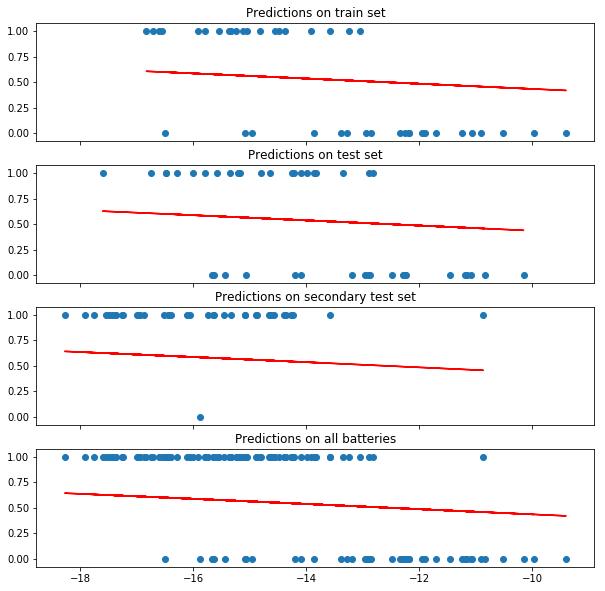

In [143]:
fig, ax = plt.subplots(4, sharex=True, figsize=(10,10))
pred_train = clf.predict_proba(x_train)[:,1]
ax[0].scatter(x_train, y_train)
ax[0].plot(x_train, pred_train, color="red")
ax[0].set_title("Predictions on train set")

pred_test = clf.predict_proba(x_test)[:,1]
ax[1].scatter(x_test, y_test)
ax[1].plot(x_test, pred_test, color="red")
ax[1].set_title("Predictions on test set")

pred_test_sec = clf.predict_proba(x_test_sec)[:,1]
ax[2].scatter(x_test_sec, y_test_sec)
ax[2].plot(x_test_sec, pred_test_sec, color="red")
ax[2].set_title("Predictions on secondary test set")

pred_all = clf.predict_proba(df["Delta_Qd_5_4_log_variance"][:,np.newaxis])[:,1]
ax[3].scatter(df["Delta_Qd_5_4_log_variance"], df["cycle_life"])
ax[3].plot(df["Delta_Qd_5_4_log_variance"], pred_all, color="red")
ax[3].set_title("Predictions on all batteries")
plt.show()

In [55]:
varclf_acc_train = accuracy_score(clf.predict(x_train), y_train.values.ravel())
varclf_acc_test = accuracy_score(clf.predict(x_test), y_test.values.ravel())
varclf_acc_test_sec = accuracy_score(clf.predict(x_test_sec), y_test_sec.values.ravel())

In [56]:
df_metrics = pd.DataFrame({"Classifier":["Variance classifier", "Full classifier"],
              "Acc - Train": [varclf_acc_train,0],
              "Acc - Primary test": [varclf_acc_test,0],
              "Acc - Secondary test": [varclf_acc_test_sec,0]})                                  
df_metrics

,Classifier,Acc - Train,Acc - Primary test,Acc - Secondary test
0,Variance classifier,0.804878,0.767442,0.95
1,Full classifier,0.000000,0.000000,0.00


In [47]:
# plotting the Variance model, to get an intuition of of how the scores are computed
fig, ax = plt.subplots(4, sharex=True, figsize=(10,10))
pred_train = lin_reg.predict(x_train)
ax[0].scatter(x_train, y_train)
ax[0].plot(x_train, pred_train, color="red")
ax[0].set_title("Predictions on train set")
pred_test = lin_reg.predict(x_test)
ax[1].scatter(x_test, y_test)
ax[1].plot(x_test, pred_test, color="red")
ax[1].set_title("Predictions on test set")
pred_test_sec = lin_reg.predict(x_test_sec)
ax[2].scatter(x_test_sec, y_test_sec)
ax[2].plot(x_test_sec, pred_test_sec, color="red")
ax[2].set_title("Predictions on secondary test set")
pred_all = lin_reg.predict(df.loc[:,varmod_features])
ax[3].scatter(df.loc[:,varmod_features], df.loc[:,target])
ax[3].plot(df.loc[:,varmod_features], pred_all, color="red")
ax[3].set_title("Predictions on all batteries")
plt.show()

NameError: name 'plt' is not defined